In [ ]:
! pip install -q "datasets==2.20.0" "flash_attn==2.6.3" "timm==1.0.8" "einops==0.8.0" "transformers==4.44.0" pillow huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
import requests
from PIL import Image
import random

In [ ]:
# Load the dataset in streaming mode for trainig
dataset = load_dataset("yasimed/lung_cancer", split='train', streaming=True)

# Convert the streaming dataset to a list of dictionaries
data = list(dataset)

random.seed(42)
random.shuffle(data)

# Split the data into 400 training and 200 testing samples
train_data = data[:400]
test_data = data[400:600]

print(train_data[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=403x193 at 0x7F80D414F670>, 'text': 'an ultrasound photo of large cell carcinoma lung cancer'}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

# Before Training the Model

Test the base model

In [ ]:
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

for idx in range(3):
  print(run_example("DocVQA", 'What is this image?', train_data[idx]['image']))


{'DocVQA': 'unanswerable'}
{'DocVQA': 'no'}
{'DocVQA': 'unanswerable'}


# Dataset Preparation

In [ ]:
class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + "What is the type of lung cancer?"
        first_answer = example['text']
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image

train_dataset = DocVQADataset(train_data)
val_dataset = DocVQADataset(test_data)

In [ ]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

batch_size = 2
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

# Train Model

In [ ]:
from transformers import AdamW, AutoProcessor, get_scheduler

In [ ]:
def train_model(train_loader, val_loader, model, processor, epochs=5, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [ ]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, val_loader, model, processor)

# Evaluation

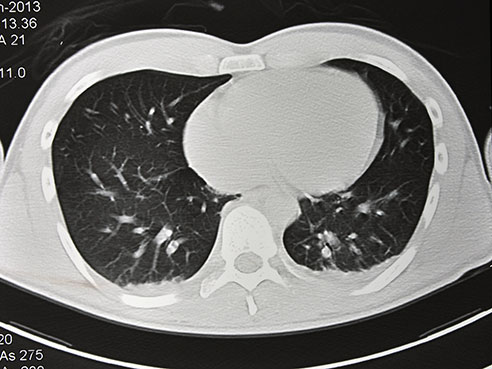

In [15]:
url = "https://www.uab.edu/news/images/ct_scan.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [16]:
run_example("DocVQA", 'What is the type of lung cancer', image)

{'DocVQA': 'an ultrasound photo of normal lung'}

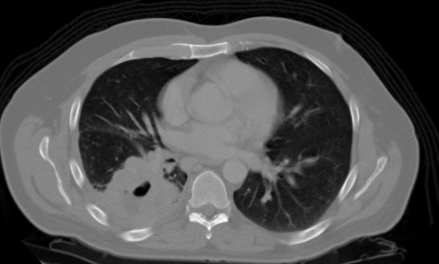

In [13]:
image = Image.open("/content/image.png").convert("RGB")
image

In [14]:
run_example("DocVQA", 'What is the type of lung cancer', image)

{'DocVQA': 'an ultrasound photo of adenocarcinoma lung cancer'}